## Code for Figure 1 of manuscript

In [1]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive/UT_world_model/Worldmodel/vega-reproducibility/src"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UT_world_model/Worldmodel/vega-reproducibility/src


In [2]:
!pip install scanpy

In [3]:
import sys
import os
sys.path.append('../src/')
from vega_model import VEGA
from utils import *
import torch
torch.manual_seed(0)
np.random.seed(0)
import pandas as pd
import umap
import scanpy as sc
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
import seaborn as sns
# Reload data
adata_train = sc.read('../data/train_pbmc.h5ad')
# Reload pathway
pathway_dict = read_gmt('../data/reactomes.gmt')
n = 1
pathway_list = list(pathway_dict.keys())+['UNANNOTATED_'+str(k) for k in range(n)]
pathway_mask = create_pathway_mask(adata_train.var.index.tolist(), pathway_dict, add_missing=n, fully_connected=True)

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [4]:
# Read results npy
path_models = '../trained_models/kang_pbmc/'
res_f = '10CV_vega_kang_pbmc.npy'
out = np.load(path_models+res_f, allow_pickle=True).item()
best_f = 0
best_l = 99999
for fold in out.keys():
    l = out[fold]['best_valid_loss']
    print(fold, l)
    if l < best_l:
        best_f = fold
        best_l = l

0 167.88057121863733
1 165.73775247427133
2 169.07398986816406
3 168.7048105093149
4 168.34021700345554
5 169.05157470703125
6 169.07010650634766
7 167.66521336482123
8 167.0422598031851
9 167.62367189847507


In [5]:
vae = VEGA(pathway_mask=pathway_mask, positive_decoder=True)
vae.load_state_dict(torch.load(path_models+'vega_kang_pbmc_fold_%s.pt'%(best_f), map_location=torch.device('cpu')))
# Set to eval
vae.eval()

0.2
Constraining decoder to positive weights


VEGA(
  (encoder): Sequential(
    (0): Linear(in_features=6998, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=800, out_features=800, bias=True)
    (5): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (mean): Sequential(
    (0): Linear(in_features=800, out_features=675, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (logvar): Sequential(
    (0): Linear(in_features=800, out_features=675, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (decoder): CustomizedLinear(input_features=675, output_features=6998, bias=True)
)

In [6]:
adata_train.obs['Immune System'] = ['Innate' if c in ['CD14+Mono','FCGR3A+Mono', 'Dendritic'] else 'Adaptive' for c in adata_train.obs['cell_type'] ]

# Umap figs

In [7]:
z = vae.to_latent(torch.Tensor(adata_train.X.A)).detach().numpy()
pathway_encoded_df = pd.DataFrame(data=z, index=adata_train.obs.index.tolist(), columns=pathway_list)

In [8]:
reducer = umap.UMAP(random_state=42, min_dist=0.5, n_neighbors=15)
embedding = reducer.fit_transform(z)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


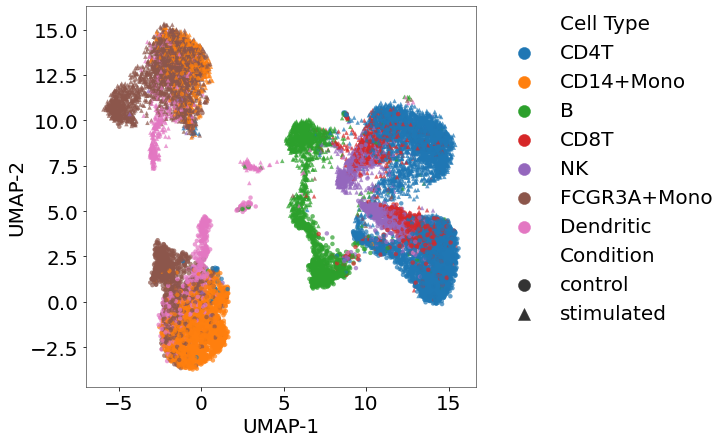

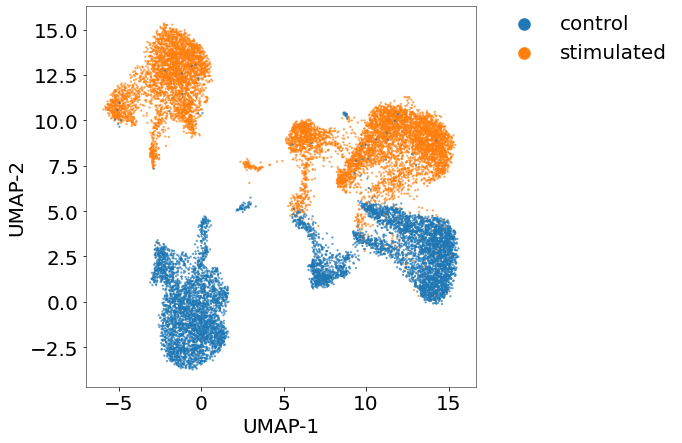

In [9]:
umap_df = pd.DataFrame({'UMAP-1':embedding[:,0], 'UMAP-2':embedding[:,1],
                        'Cell Type':adata_train.obs['cell_type'], 'Condition':adata_train.obs['condition']})
plt.figure(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cell Type', data=umap_df, style='Condition', markers=['o','^'],
                linewidth=0, alpha=0.7, s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
#plt.legend(frameon=False, ncol=1, fontsize=13, markerscale=1.5)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('../paper/figures/fig1-ct-cond-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Condition', data=umap_df,
                linewidth=0, alpha=0.7, s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('../paper/figures/fig1-b-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


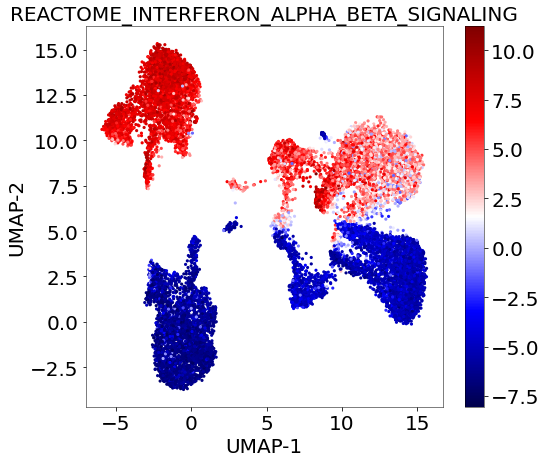

In [10]:
plt.figure(figsize=[8,7])
plt.scatter(embedding[:,0], embedding[:,1], alpha = 1, linewidths=0,
            c = pathway_encoded_df['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'], marker='o', s=10, cmap = 'seismic')
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
plt.title('REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', fontsize=20)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('../paper/figures/fig1-ifn-umap-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Bivariate plot

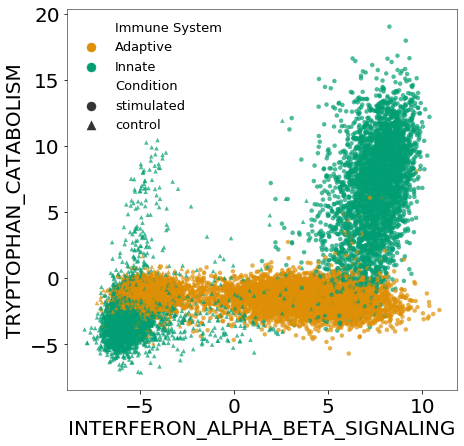

In [ ]:
plt.figure(figsize=[7,7])
cdict = {'Adaptive':"#DE8F05", 'Innate':"#029E73"}
sns.scatterplot(x=pathway_encoded_df['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'],
            y=pathway_encoded_df['REACTOME_TRYPTOPHAN_CATABOLISM'],
            hue=adata_train.obs['Immune System'], style=umap_df['Condition'],markers=['o','^'], palette=cdict,
           linewidth=0, alpha=0.7, s=20)
plt.xlabel('INTERFERON_ALPHA_BETA_SIGNALING',fontsize=20)
plt.ylabel('TRYPTOPHAN_CATABOLISM',fontsize=20)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.legend(frameon=False, ncol=1, fontsize=13, markerscale=1.5)
plt.tick_params(labelsize=20)
#plt.savefig('../paper/figures/fig1-trp-ifn-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

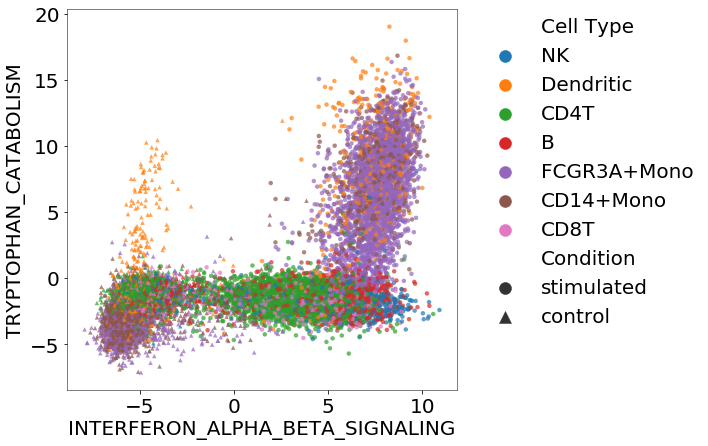

In [ ]:
plt.figure(figsize=[7,7])
sns.scatterplot(x=pathway_encoded_df['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'],
            y=pathway_encoded_df['REACTOME_TRYPTOPHAN_CATABOLISM'],
            hue=umap_df['Cell Type'], style=umap_df['Condition'],markers=['o','^'],
           linewidth=0, alpha=0.7, s=20)
plt.xlabel('INTERFERON_ALPHA_BETA_SIGNALING',fontsize=20)
plt.ylabel('TRYPTOPHAN_CATABOLISM',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.tick_params(labelsize=20)
#plt.savefig('../paper/figures/fig1-trp-ifn-deep-ct-lbl.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Differential Factor Activation between Innate Immune Cells

In [ ]:
# Volcano plot
from adjustText import adjust_text

def plot_dfe(dfe_res,
             pathway_list,
             sig_lvl,
             lfc_lvl,
             to_plot=None,
             metric='mad',
             figsize=[12,5],
             s=10,
             fontsize=10,
             textsize=8,
             title=False,
             save=False):
    """
    Plot Differential Factor Expression results.
    Args:
        dfe_res (dict): dictionary with differential factor analysis results from VAE.
        pathway_list (list): list with name of factors
        sig_lvl (float): log_e(BF) threshold for significance.
        lfc_lvl (float): threshold for metric significance level (MAD or LFC).
        to_plot (dict): subset of factors to annotate on plot. If None, defaults to all significant (sig_lvl, lfc_lvl).
        metric (str): Metric to use for Y-axis. 'mad' or 'lfc' (default:'mad').
        figsize (tuple): figure size.
        s (int): size of dots for scatter.
        fontsize (int): size of text on axes.
        textsize (int): size of text for annotation on plot.
        title (str): plot title (optional).
        save (str): path to save figure (optional).
    """
    # Init plot
    plt.figure(figsize=figsize)
    xlim_v = np.abs(dfe_res['bayes_factor']).max() + 0.5
    ylim_v = dfe_res[metric].max()+0.5

    idx_sig = np.arange(len(dfe_res['bayes_factor']))[(np.abs(dfe_res['bayes_factor'])>sig_lvl) & (np.abs(dfe_res[metric])>lfc_lvl)]
    plt.scatter(dfe_res['bayes_factor'], dfe_res[metric], color='grey', s=s, alpha=0.8, linewidth=0)
    #plt.scatter(dfe_res['bayes_factor'][dfe_res['s_values'] <= 0.1], dfe_res[metric][dfe_res['s_values'] <= 0.1], color='black', s=5, alpha=1)
    plt.scatter(dfe_res['bayes_factor'][idx_sig], dfe_res[metric][idx_sig], color='red', s=s*2, linewidth=0)
    plt.vlines(x=-sig_lvl, ymin=-0.5, ymax=ylim_v, color='black', linestyles='--', linewidth=1., alpha=0.2)
    plt.vlines(x=sig_lvl, ymin=-0.5, ymax=ylim_v, color='black', linestyles='--', linewidth=1., alpha=0.2)
    plt.hlines(y=lfc_lvl, xmin=-xlim_v, xmax=xlim_v, color='black', linestyles='--', linewidth=1., alpha=0.2)
    texts = []
    
    if to_plot is None:
        for i in idx_sig:
            name = pathway_list[i]
            x = dfe_res['bayes_factor'][i]
            y = dfe_res[metric][i]
            texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':textsize}))
    else:
        idx_plot = [(pathway_list.index(f),to_plot[f]) for f in to_plot]
        for i in idx_plot:
            name = i[1]
            x = dfe_res['bayes_factor'][i[0]]
            y = dfe_res[metric][i[0]]
            #if y < 5.5:
            texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':textsize}))
            
    # Cosmetics
    plt.xlabel(r'$\log_e$(Bayes factor)', fontsize=fontsize)
    if metric == 'mad':
        plt.ylabel('MAD', fontsize=fontsize)
    else:
        plt.ylabel(r'$\log{|(FC_{z})|}$', fontsize=fontsize)
    plt.ylim([0,ylim_v])
    plt.xlim([-xlim_v,xlim_v])
    if title:
        plt.title(title+'(|K|>%.1f)'%(sig_lvl))
    adjust_text(texts, only_move={'texts':'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=2))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    #plt.grid()
    #adjust_text(texts)
    if save:
        plt.savefig(save, format='pdf', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
adata_ctrl = adata_train[adata_train.obs['condition']=='control',:].copy()
adata_stim = adata_train[adata_train.obs['condition']=='stimulated',:].copy()
adata_ctrl.X = adata_ctrl.X.A
adata_stim.X = adata_stim.X.A
adata_ctrl.obs['is_Innate'] = np.isin(adata_ctrl.obs['cell_type'], ['CD14+Mono','FCGR3A+Mono', 'Dendritic'])
adata_stim.obs['is_Innate'] = np.isin(adata_stim.obs['cell_type'], ['CD14+Mono','FCGR3A+Mono', 'Dendritic'])
adata_ctrl = adata_ctrl[adata_ctrl.obs['is_Innate'], :].copy()
adata_stim = adata_stim[adata_stim.obs['is_Innate'], :].copy()
dfe_res = vae.bayesian_diff_exp(adata_stim, adata_ctrl, n_samples=5000, use_permutations=True, n_permutations=10000, random_seed=0)

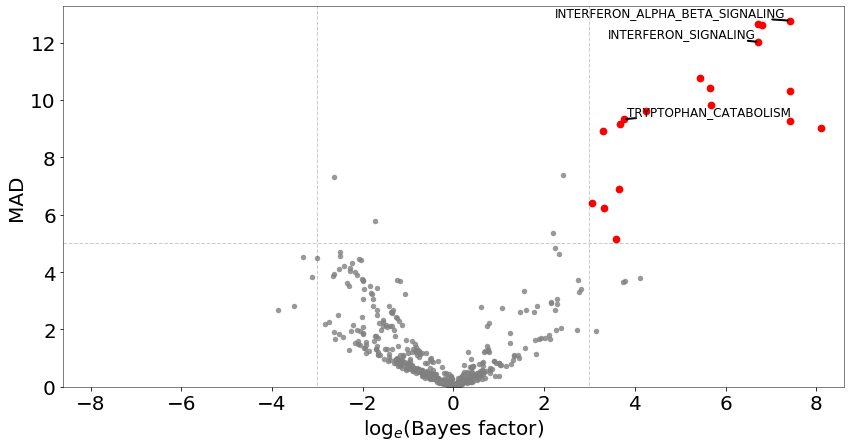

In [ ]:
plot_dfe(dfe_res,
         sig_lvl=3.,
         pathway_list=pathway_list,
         lfc_lvl=5.,
         to_plot={'REACTOME_INTERFERON_SIGNALING':'INTERFERON_SIGNALING',
                  'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING':'INTERFERON_ALPHA_BETA_SIGNALING',
                  'REACTOME_TRYPTOPHAN_CATABOLISM':'TRYPTOPHAN_CATABOLISM'},
         figsize=[14,7],
         s=30,
         fontsize=20,
         textsize=12,
         save=False)#'../paper/figures/fig1-volcano-deep.pdf')

## GSEA comparison

In [ ]:
adata_gs_innate = adata_train[np.isin(adata_train.obs['cell_type'], ['CD14+Mono','FCGR3A+Mono', 'Dendritic'])]

In [ ]:
import gseapy as gp
sc.tl.rank_genes_groups(adata_gs_innate, groupby='condition', method='wilcoxon', n_genes=len(adata_gs_innate),
                        use_raw=True)
names = adata_gs_innate.uns['rank_genes_groups']['names']['stimulated']
#scores = adata_gs_innate.uns['rank_genes_groups']['logfoldchanges']['stimulated']
scores = adata_gs_innate.uns['rank_genes_groups']['scores']['stimulated']
# Wrap
df = pd.DataFrame({'0':names, '1':scores})
df = df.sort_values(by=['1'], ascending=False)
pre_res = gp.prerank(rnk=df, gene_sets='../data/reactomes.gmt',
                     processes=4,
                     permutation_num=1000, min_size=5, max_size=1000, outdir=None)
gsea_res = pre_res.res2d

/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Immune System' as categorical


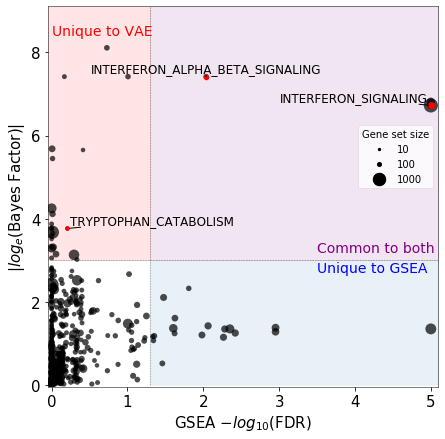

In [ ]:
# Correlation plot GSEA -log10(FDR) / VAE |K|
from matplotlib import patches
from matplotlib.lines import Line2D

bf_cutoff = 3.
fdr_cutoff = -np.log10(0.05)

abs_bf = np.abs(dfe_res['bayes_factor'][:-n])
fdr_sorted = np.nan_to_num(-np.log10(np.nan_to_num(gsea_res.reindex(pathway_list[:-n])['fdr'],nan=1)),posinf=5)

p_sizes = np.array([len(v) for k,v in pathway_dict.items()])
# Rescale in range [10,100]
a,b = 20,200
dot_sizes = a + ((p_sizes - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))


fig = plt.figure(figsize=[7,7])
plt.fill_between(np.linspace(fdr_cutoff,np.max(fdr_sorted)+0.1, 1000) , 0, bf_cutoff, color='C0', alpha=0.1,
                 interpolate=True)
plt.fill_between(np.linspace(fdr_cutoff,np.max(fdr_sorted)+0.1, 1000) , bf_cutoff, np.max(abs_bf)+1, color='purple', alpha=0.1,
                 interpolate=True)
plt.fill_between(np.linspace(-0.05,fdr_cutoff, 1000) , bf_cutoff, np.max(abs_bf)+1, color='r', alpha=0.1,
                 interpolate=True)


plt.hlines(xmin=np.min(fdr_sorted), xmax=np.max(fdr_sorted)+0.1, y=bf_cutoff, linestyle='--', color='k', alpha=0.5)
plt.vlines(ymin=np.min(abs_bf), ymax=np.max(abs_bf)+1, x=fdr_cutoff, linestyle='--',color='k', alpha=0.5)

plt.scatter(fdr_sorted, abs_bf, s=dot_sizes, c='k', linewidth=0, alpha=0.7)
texts = []
to_text = np.arange(len(dfe_res['bayes_factor']))[(np.abs(dfe_res['bayes_factor'])>bf_cutoff) & (np.abs(dfe_res['mad'])>3.)]
for i in to_text:
        name = pathway_list[i].split('REACTOME_')[-1]
        if 'UNANNOTATED' not in name:
            x = fdr_sorted[i]
            y = dfe_res['bayes_factor'][i]
            #if y < 5.5:
            if 'INTERFERON' in name or 'TRYPTOPHAN' in name:
                texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':12}))
                plt.scatter(x,y, s=dot_sizes[i], c='r', linewidth=0)
            

adjust_text(texts, only_move={'texts':'xy', 'arrows':'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.text(x=0, y=np.max(abs_bf)+0.3, s='Unique to VAE', fontdict={'size':14, 'color':'r'})
plt.text(x=3.5, y=bf_cutoff+0.2, s='Common to both', fontdict={'size':14, 'color':'purple'})
plt.text(x=3.5, y=bf_cutoff-0.3, s='Unique to GSEA', fontdict={'size':14, 'color':'b'})
#plt.text(x=0.7, y=2., s='n.s', fontdict={'size':12, 'color':'k'})

plt.xlabel(r'GSEA $-log_{10}$(FDR)', fontsize=15)
plt.ylabel(r'$|log_e$(Bayes Factor)|', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([-0.05,np.max(abs_bf)+1])
plt.xlim([-0.05,np.max(fdr_sorted)+0.1])

legend_sizes = a + ((np.array([10,100,1000]) - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))
legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(10), markerfacecolor='k', markersize=np.sqrt(legend_sizes[0])),
                   Line2D([0], [0], marker='o', color='w', label=str(100), markerfacecolor='k', markersize=np.sqrt(legend_sizes[1])),
                   Line2D([0], [0], marker='o', color='w', label=str(1000), markerfacecolor='k', markersize=np.sqrt(legend_sizes[2]))]

plt.legend(handles=legend_elements, title='Gene set size', loc='best', bbox_to_anchor=[1, 0.7])
#plt.savefig('../paper/figures/fig1-gsea-vae-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
# Save GSEA and VAE results to .csv
report_df = pd.DataFrame(index=pathway_list)
report_df['Bayes_Factor'] = dfe_res['bayes_factor']
report_df['Gene_set_size'] = [len(pathway_dict[i]) if i in pathway_dict else adata_train.shape[1] for i in report_df.index]
report_df['GSEA_-log10FDR'] = np.nan_to_num(-np.log10(np.nan_to_num(gsea_res.reindex(pathway_list)['fdr'],nan=1.)),posinf=5.)
report_df.to_csv('../paper/supT-vae-gsea-ifn.csv', sep=',', index=True, header=True)